FFR 120  
Felix Waldschock

HW 2  
Exercise 7.6

In [1226]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
from tqdm import trange


In [1227]:
# Simulation parameters
L = 100                                     # length of the box
sigma = 1       
dT = .01
dT = .01

N = 1000                                       # number of trajectiories (particles)
T_tot = [1000]                            # total time
T_tot = np.array(T_tot)
Iteration_Steps = T_tot * (1 / dT)          # total number of steps 
max_steps = int(np.max(Iteration_Steps))    # maximum number of steps

# parameters
n_drift = 15
n_diff = 1

x0 = 0                                      # initial position of the particle
alpha = 1
sigma0 = 1
dSigma = 1.8 

numberOfIntervalls = 100
Lk = L / numberOfIntervalls
IntervallCenters = np.linspace(0, (numberOfIntervalls-1)*Lk, numberOfIntervalls) + Lk/2 - L/2

In [1228]:
# constant noise simulation ex 7.2, create a trajectory matrix containing trajectories of all particles

def simulate_trajectory_constant(N, max_steps, L):
    # x = np.zeros(N)*x0
    x = np.random.uniform(-L/2, L/2, N)
    
    trajectories = np.zeros((N, len(T_tot)))                             # array to store trajectories  
    sigmas_ = np.zeros(N)                                                # array to store sigmas
        
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        # calc new sigma
        o = sigma * np.sqrt(dT)
        directions = np.random.choice([-1, 1], N)
        x += directions * o
        
        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)
        
        trajectoryTensor[:,s] = x
    
    trajectories[:, -1] = x
    sigmas_[:] = sigma

    
    return trajectories, sigmas_, trajectoryTensor

In [1229]:
# multiplicative noise 
def simulate_trajectory_multiplicative(N, max_steps, L, alpha):
    #x = np.ones(N)*x0
    x = np.random.uniform(-L/2, L/2, N)

    trajectories = np.zeros((N, len(T_tot)))                            # array to store trajectories  
    sigmas_ = np.zeros(N)                                               # array to store sigmas
 
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        
        # get new noise
        sigma = np.zeros(N)
        # multiplicative noise
        tmp1 = sigma0 + dSigma*x/L
        tmp2 = dSigma * dT / L
        tmp3 = tmp1 * np.sqrt(dT)
        direction = np.random.choice([-1,1], N)
        sigma = alpha * tmp1 * tmp2 + tmp3 * direction
        
        x += sigma

        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)

        trajectoryTensor[:,s] = x
    
        if s in Iteration_Steps:
            index = np.where(Iteration_Steps == s)[0][0]
            trajectories[:, index] = x

    trajectories[:, -1] = x
    sigmas_ = sigma

    return trajectories, sigmas_, trajectoryTensor


In [1230]:
# Run constant simulation
trajectories_constant, sigmas_constant, trajectoryTensor_constant = simulate_trajectory_constant(N, max_steps, L)


100%|██████████| 100000/100000 [00:01<00:00, 50207.56it/s]


In [1231]:
# Run multiplicative simulation
trajectories_multiplicative, sigmas_multiplicative, trajectoryTensor_multiplicative = simulate_trajectory_multiplicative(N, max_steps, L, alpha)
print(trajectoryTensor_multiplicative.shape)

100%|██████████| 100000/100000 [00:03<00:00, 32651.77it/s]

(1000, 100000)


In [1232]:
def computeDriftDiff(trajectoryTensor, name):
    # if a particle is in an intervall, check where it is after n_drift steps, use this difference to getDrift
    drift = np.zeros(numberOfIntervalls)
    driftCounter = np.ones(numberOfIntervalls)
    diff = np.zeros(numberOfIntervalls)
    diffCounter = np.ones(numberOfIntervalls)

    # trajecoryTensor comes in dimension (N, max_steps)
    numP = trajectoryTensor.shape[0]
    numSteps = trajectoryTensor.shape[1]

    # loop over all particles
    for p in trange(numP):
        # loop over all time steps
            for s in range(numSteps-n_drift-1):
                currentParticle = trajectoryTensor[p, s]
                # check from which intervallCenter the particle lays < Lk/2 away
                intervallIndex = np.where(np.abs(currentParticle - IntervallCenters) <= Lk/2)[0][0]

                # check where the particle is after n_drift steps and add to drift array, increment counter
                driftDifference = trajectoryTensor[p,s+n_drift] - currentParticle
                diffDifference = trajectoryTensor[p,s+n_diff] - currentParticle

                drift[intervallIndex] += driftDifference
                if(driftDifference != 0):
                    driftCounter[intervallIndex] += 1
                diff[intervallIndex] += diffDifference**2
                if(diffDifference != 0):
                    diffCounter[intervallIndex] += 1


    # save diff and diffCounter
    np.save("diff_"+name+".npy", diff)
    np.save("diffCounter_"+name+".npy", diffCounter)

    # implement the formulas 7.13 / 7.14

    # 7.13
    drift = drift/driftCounter
    drift = drift/(dT * n_drift)

    # square the delta of diffusions
    #diff = diff**2 
    # take average
    diff = diff/diffCounter

    diff = diff/(dT * n_diff *2)

    #print(driftCounter)

    if np.isnan(drift).all():
        print("drift nan")

    # print(drift)

    # if nan set to zero  
    drift[np.isnan(drift)] = 0
    diff[np.isnan(diff)] = 0

    return drift, driftCounter, diff, diffCounter

In [1233]:
# def computeDriftDiff(trajectoryTensor, name):
#     # if a particle is in an intervall, check where it is after n_drift steps, use this difference to getDrift
#     drift = np.zeros(numberOfIntervalls)
#     driftCounter = np.ones(numberOfIntervalls)
#     diff = np.zeros(numberOfIntervalls)
#     diffCounter = np.ones(numberOfIntervalls)

#     # trajecoryTensor comes in dimension (N, max_steps)
#     numP = trajectoryTensor.shape[0]
#     numSteps = trajectoryTensor.shape[1]

#     # loop over all particles
#     for t in trange(numP):
#         # loop over all time steps

#         # take the time column of the trajectoryTensor
#         currentParticles = trajectoryTensor[:,t]
#         print(currentParticles.shape)
        
#         intervallIndexes = np.where(np.abs(currentParticles - IntervallCenters) <= Lk/2)[0][0]

#         driftParticles = trajectoryTensor[t+n_drift,:]
#         diffParticles = trajectoryTensor[t+n_diff,:]

#         driftDifference = driftParticles - currentParticles
#         diffDifference = diffParticles - currentParticles

#         drift += driftParticles
#         diff += diffParticles

#         # if differences != 0, increment the counter
#         driftCounter[intervallIndexes] += np.where(driftDifference != 0)[0].shape[0]
#         diffCounter[intervallIndexes] += np.where(diffDifference != 0)[0].shape[0]



#             # for s in range(numSteps-n_drift-1):
#             #     currentParticle = trajectoryTensor[t, s]
#             #     # check from which intervallCenter the particle lays < Lk/2 away
#             #     intervallIndex = np.where(np.abs(currentParticle - IntervallCenters) <= Lk/2)[0][0]
#             #     #print(intervallIndex)
#             #     # check where the particle is after n_drift steps and add to drift array, increment counter
#             #     driftDifference = trajectoryTensor[t,s+n_drift] - currentParticle
#             #     diffDifference = trajectoryTensor[t,s+n_diff] - currentParticle


#             #     drift[intervallIndex] += driftDifference
#             #     if(driftDifference != 0):
#             #         driftCounter[intervallIndex] += 1
#             #     diff[intervallIndex] += diffDifference
#             #     if(diffDifference != 0):
#             #         diffCounter[intervallIndex] += 1


#     # save diff and diffCounter
#     np.save("diff_"+name+".npy", diff)
#     np.save("diffCounter_"+name+".npy", diffCounter)

#     # implement the formulas 7.13 / 7.14

#     # 7.13
#     drift = drift/driftCounter
#     drift = drift/(dT * n_drift)

#     # square the delta of diffusions
#     diff = diff**2 
#     # take average
#     diff = diff/diffCounter

#     diff = diff/(dT * n_diff *2)

#     #print(driftCounter)

#     if np.isnan(drift).all():
#         print("drift nan")

#     # print(drift)

#     # if nan set to zero  
#     drift[np.isnan(drift)] = 0
#     diff[np.isnan(diff)] = 0

#     return drift, driftCounter, diff, diffCounter

In [1234]:
# compute the drift and diffusion for both simulation trajectories
if(1):
    drift_constant, driftCounter_const, diffusion_constant, diffCounter_const = computeDriftDiff(trajectoryTensor_constant,"const")



100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


In [1235]:
if(1):
    drift_multiplicative, driftCounter_mult, diffusion_multiplicative, diffCounter_mult = computeDriftDiff(trajectoryTensor_multiplicative,"mult")


100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [1236]:
def lowPassFilter(array, tau, state):
    # simple low pass filter to smooth the data
    # tau is the time constant
    # array is the array to be smoothed
    # returns the smoothed array


    # bypass
    if(state==0):
        return array

    smoothedArray = np.zeros(len(array))
    smoothedArray[0] = array[0]
    for i in range(1, len(array)):
        smoothedArray[i] = smoothedArray[i-1] + (array[i] - smoothedArray[i-1]) * dT / tau
    return smoothedArray

In [1237]:
# calculate the noise induced drift -> derivative of the diffusion
def calcNoiseInducedDrift(diffusion, dT):
    return lowPassFilter(diffusion, dT, True)

In [1238]:
# calculate the noise induced drift -> derivative of the diffusion
noiseInducedConstant = calcNoiseInducedDrift(diffusion_constant, dT)
noiseInducedMultiplicative = calcNoiseInducedDrift(diffusion_multiplicative, dT)

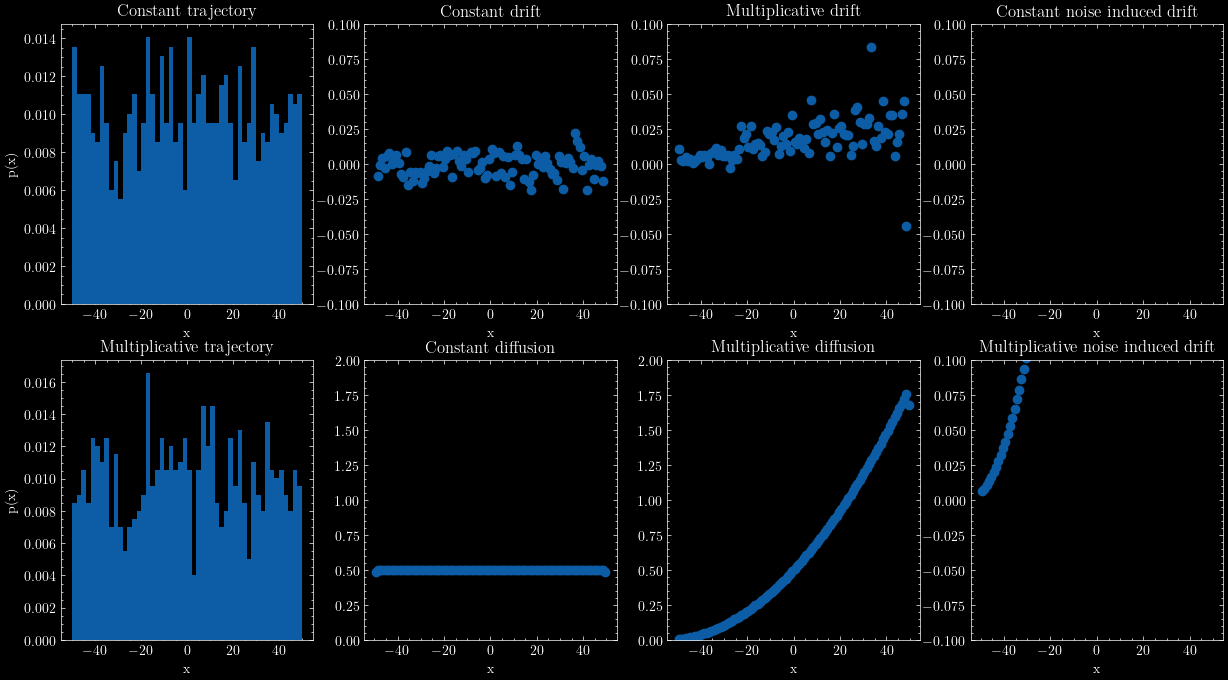

In [1239]:
# plot a 2x3 subplot
fig, axs = plt.subplots(2, 4, figsize=(15,8))
x_init = np.linspace(-L/2, L/2, N)

# plot the constantDrift and conStantDiffusion in 1 and 2
axs[0, 0].hist(trajectories_constant, bins=50, density=True, label='constant drift')
axs[0, 0].set_title('Constant trajectory')
axs[0, 0].set(ylabel='p(x)')

axs[1, 0].hist(trajectories_multiplicative, bins=50, density=True, label='multiplicative trajectory')
axs[1, 0].set_title('Multiplicative trajectory')
axs[1, 0].set(ylabel='p(x)')

axs[0, 1].plot(IntervallCenters,drift_constant, 'o',label='constant noise')
axs[0, 1].set_title('Constant drift')
axs[0, 1].set_ylim(-0.1, 0.1)

axs[1, 1].plot(IntervallCenters,diffusion_constant,'o', label='constant noise')
axs[1, 1].set_title('Constant diffusion')
axs[1, 1].set_ylim(-0, 2)

axs[0, 2].plot(IntervallCenters,drift_multiplicative, 'o', label='multiplicative noise')
axs[0, 2].set_title('Multiplicative drift')
axs[0, 2].set_ylim(-0.1, 0.1)

axs[1, 2].plot(IntervallCenters,diffusion_multiplicative,'o', label='multiplicative noise')
axs[1, 2].set_title('Multiplicative diffusion')
axs[1, 2].set_ylim(-0, 2)

axs[0, 3].plot(IntervallCenters,noiseInducedConstant, 'o',label='constant noise')
axs[0, 3].set_title('Constant noise induced drift')
axs[0, 3].set_ylim(-0.1, 0.1)

axs[1, 3].plot(IntervallCenters,noiseInducedMultiplicative, 'o',label='multiplicative noise')
axs[1, 3].set_title('Multiplicative noise induced drift')
axs[1, 3].set_ylim(-0.1, 0.1)



# set x label for all plots "x"
for ax in axs.flat:
    ax.set(xlabel='x')

# d)
Yes there is a trendline with slope > 0, indicating that particles evaulated with multiplicative noise are tend to drift more as x increases.

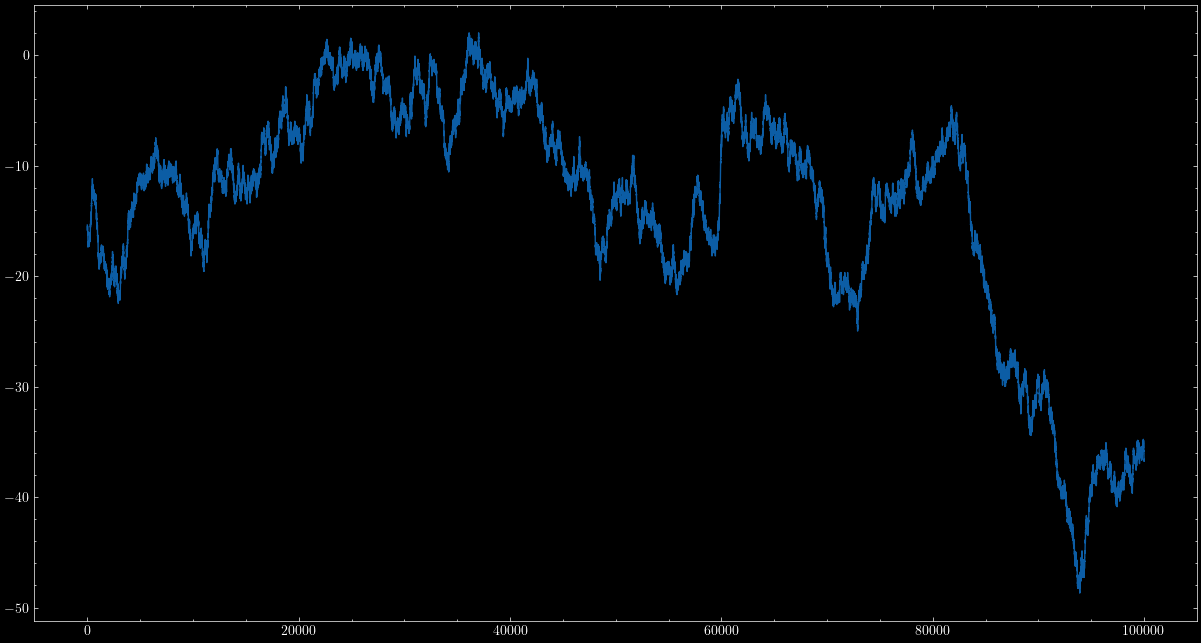

In [1240]:
# plot the trajectory of the constant noise simulation
fig = plt.figure(figsize=(15,8))
plt.plot(trajectoryTensor_constant[0,:], label='constant noise')
plt.show()

In [1241]:
a = np.array([1,2,np.nan])

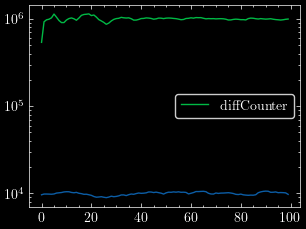

<function matplotlib.pyplot.show(close=None, block=None)>

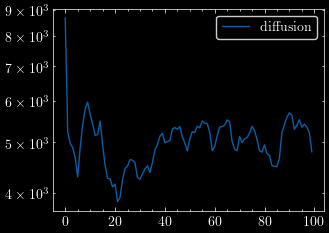

In [1242]:
diff = np.load("diff_const.npy")
diffCounter = np.load("diffCounter_mult.npy")

plt.semilogy(diff)
plt.plot(diffCounter, label="diffCounter")
plt.legend()
plt.show()
plt.semilogy((diff**2)/(diffCounter*dT * 2 * n_diff), label="diffusion")
plt.legend()
plt.show



100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]

(100,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 25.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


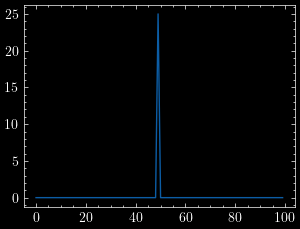

In [1243]:
# artificial trajectory

t = np.array([[-0,1,2,1,2,3,1,2,9,4,5,6,1,2,3,4,5]])
#get drift and diff
drift, driftCounter, diff, diffCounter = computeDriftDiff(t,"artificial")

print(drift.shape)
print(diff)
plt.plot(diff)

(0.0, 2.0)

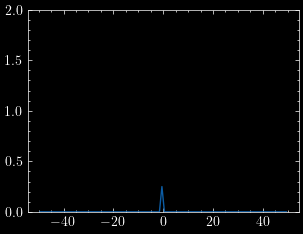

In [1244]:
# load artificial drift and diff
diff = np.load("diff_artificial.npy")
diffCounter = np.load("diffCounter_artificial.npy")
# plt.plot(diff)
# plt.plot(diff/diffCounter)
# plt.plot(diff**2)
# plt.plot((diff**2)/(diffCounter))
plt.plot(IntervallCenters,(diff**2)/(diffCounter* 2 * n_diff))
plt.ylim(0, 2)